# INF-0616 - Projeto 2: Redes neurais

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitor: Jesus Paucar -- j236865@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  

Instituto de Computação - Unicamp 2025

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

In [2]:
plt.rcParams['figure.figsize'] = (12, 6)

#### Lendo o conjunto de dados

O conjunto de dados consiste em reclamações de clientes a cerca de produtos/serviços oferecidos em uma instituição bancária. ***Garanta que o arquivo*** `customer-issues.csv` ***está no mesmo diretório do notebook***.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# caminho_pasta = '/content/drive/My Drive/Colab/MDC/AULA4/'

# # Verifique se o caminho da pasta existe
# if os.path.exists(caminho_pasta):
#     # Mude o diretório atual para a pasta desejada
#     os.chdir(caminho_pasta)
#     print("Pasta encontrada. Agora você está na pasta:", caminho_pasta)
# else:
#     print("A pasta especificada não existe:", caminho_pasta)

d = pd.read_csv('customer-issues.csv')
display(d.head())


,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


##### Exibindo as quatro primeiras mensagens

In [4]:
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

##### Extraíndo um conjunto de testes válido

As mensagens contidas neste conjunto possuem uma relação temporal.
É importante realizar a separação dos sub-conjuntos de treino/teste respeitando esta relação, de forma a garantir que o modelo não seja treinado sobre amostras no futuro e experimentado sobre o passado.

In [5]:
np.random.seed(42)
d.sort_values(by='date-received', inplace=True)

### Modelando a classificação de tópicos baseado nas mensagens de clientes

Observando no gráfico de frequências de produto sobre as conversas que este é um problema extremamente desbalanceado. Há, entretanto, amostras suficientes para a modelagem de um estimador de tópico (de produto) levando em consideração o diálogo do cliente.

In [6]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    (sns
     .barplot(x=[l[:40] for l in labels], y=counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)

    return labels, counts

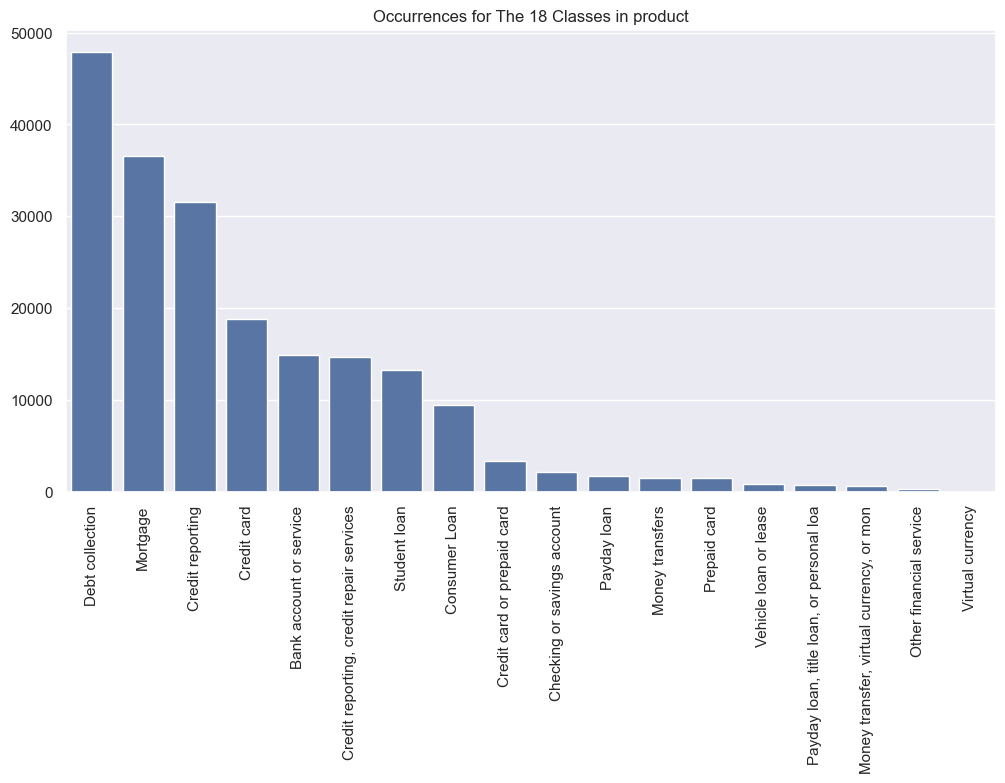

In [7]:
labels, counamts = frequencies(d, 'product')

Simplificamos o problema, considerando somente as 6 classes mais frequentes:

In [8]:
np.random.seed(42)
s = d['product'].isin(labels[:6])
d = d[s]

test_share = .3

d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

Vamos codificar as palavras na conversa utilizando o TF-IDF, gerando um vetor de características baseadas nas frequências de ocorrência das palavras no documento e em todo o conjunto de dados.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

## Treinando um regressor logístico para classificar produto
**Atividade (1 pt):** treine um regressor logístico, buscando os hiper-parâmetros com *grid-search*.

In [10]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
np.random.seed(42)

LR = LogisticRegression(
        max_iter=1000,
        random_state=42
    )

grid = {
    "C": [1e-3, 1e-2, 1e-1, 1, 10, 100],
    "class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

g = GridSearchCV(
    estimator=LR,
    param_grid=grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True
)
g.fit(x_train, ye_train)


,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.001, 0.01, ...], 'class_weight': [None, 'balanced']}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


Iremos calcular a matriz de confusão relativa $R$, que guarda porcentagens de incidências em vez das contagens absolutas, e plotar o heatmap dessa matriz. Além disso, iremos calcular a distribuição de confiança nas predições por classe (mais próximos de `1.0` --> mais confiante):

In [11]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print(f'Accuracy: {metrics.accuracy_score(y, p):.3f}')
    print(f'Accuracy (balanced): {metrics.balanced_accuracy_score(y, p):.3f}')

    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)

    # Impressão dos gráficos.
    (plt
     .figure(figsize=(16, 12))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)

    (plt
     .figure(figsize=(16, 12))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))

    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        sns.kdeplot(x = probabilities[y.ravel() == i][:, i],
                    fill = True,
                    label = labels[i] if labels is not None else f'Classe {i}',
                    alpha = 0.4)

    plt.xlabel("Confiança do modelo")
    plt.ylabel("Densidade")
    plt.legend()

Vamos utilizar a função `evaluate` para avaliar o modelo treinado anteriormente:

Accuracy: 0.754
Accuracy (balanced): 0.748


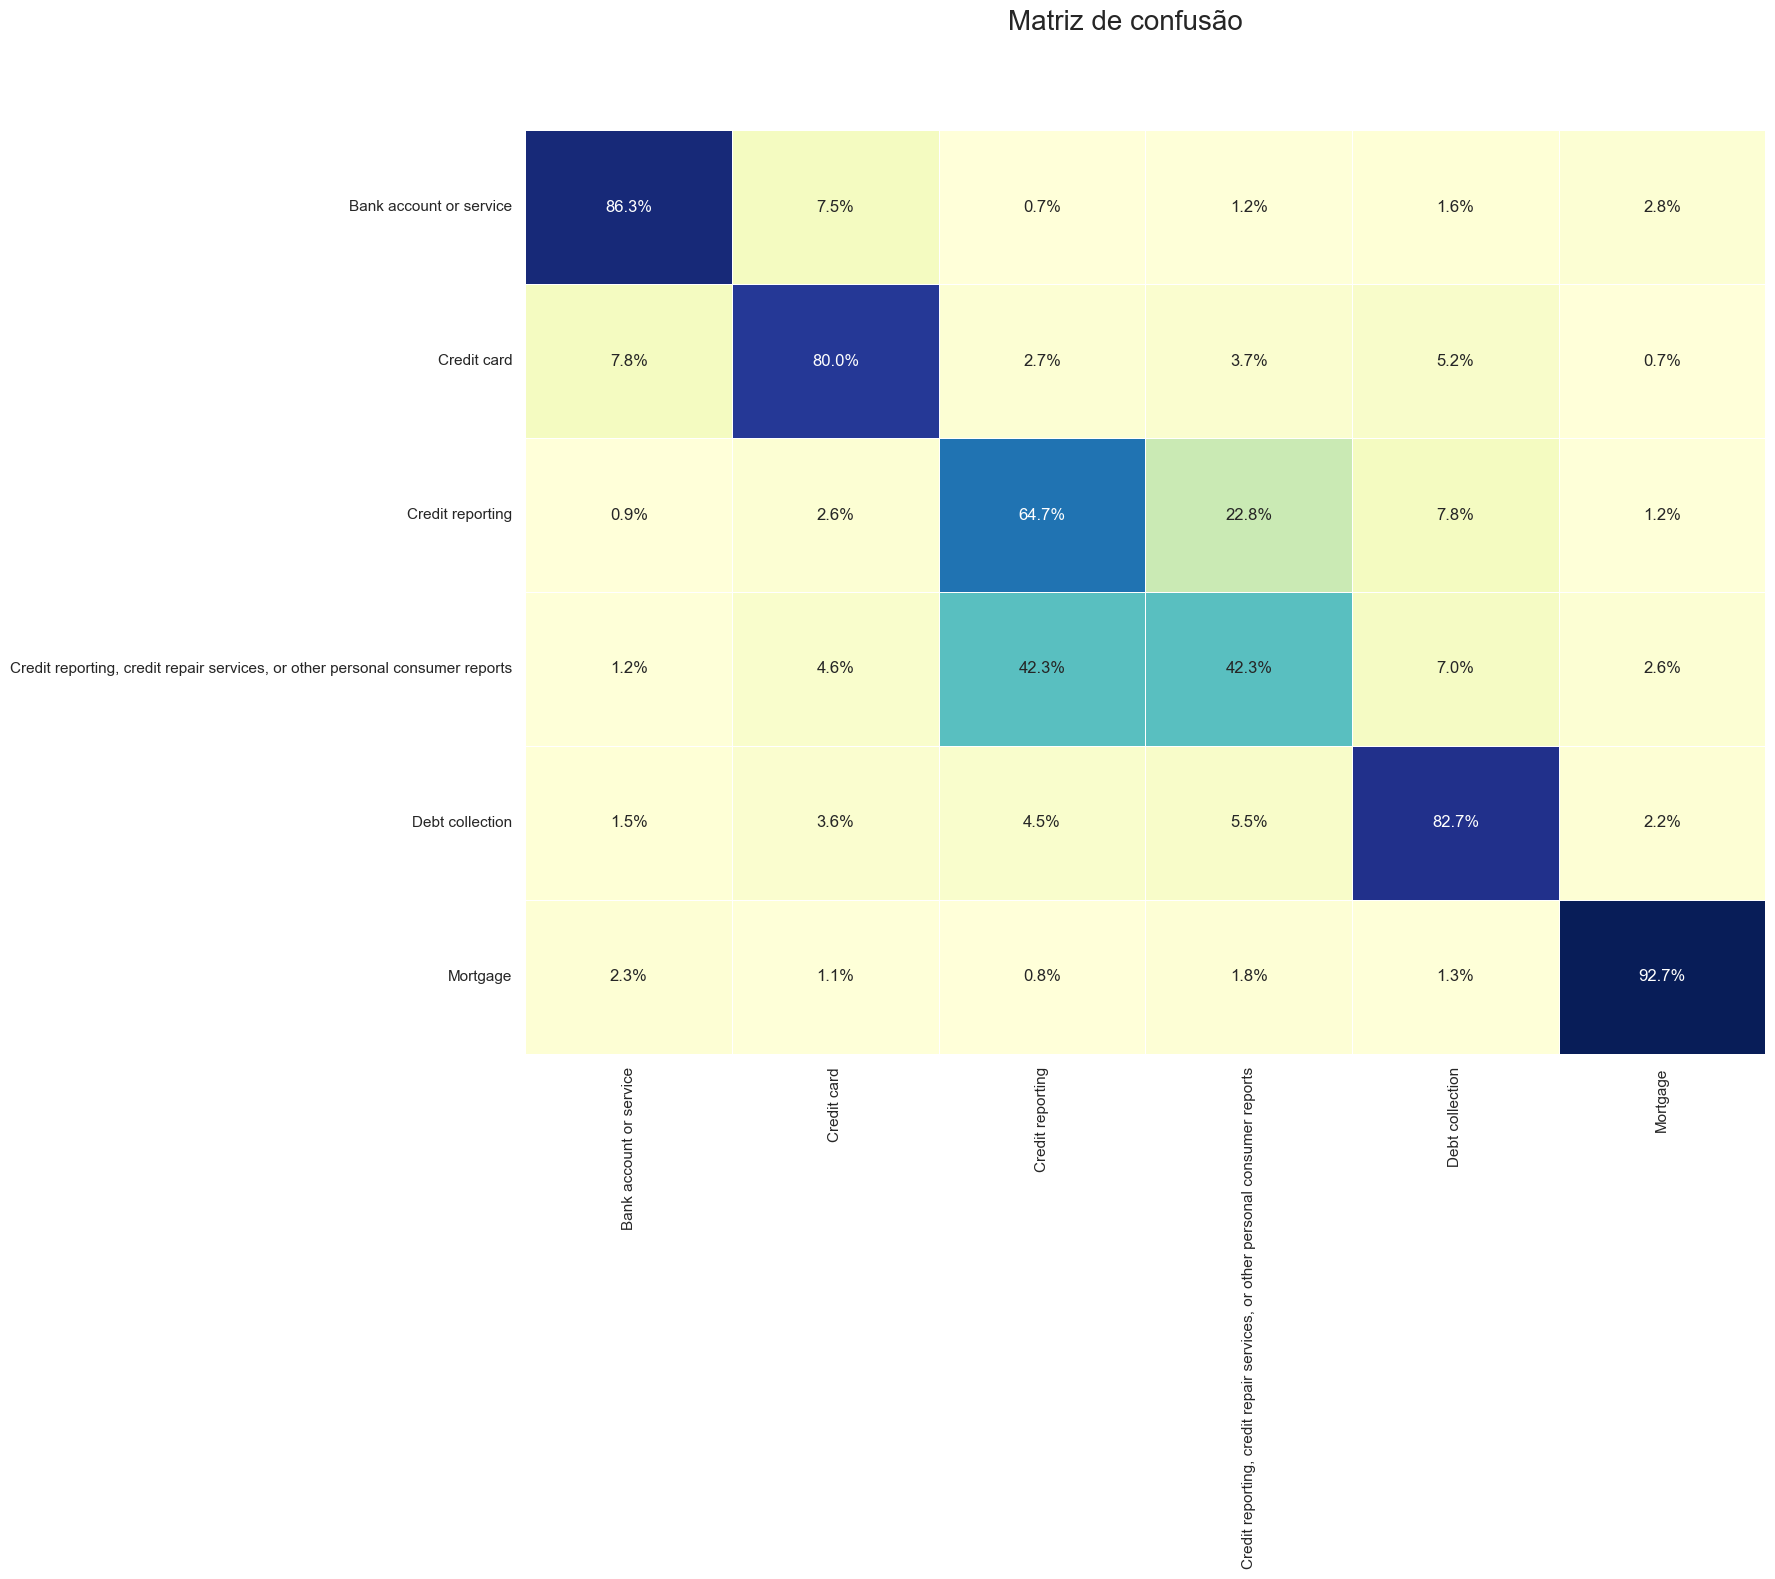

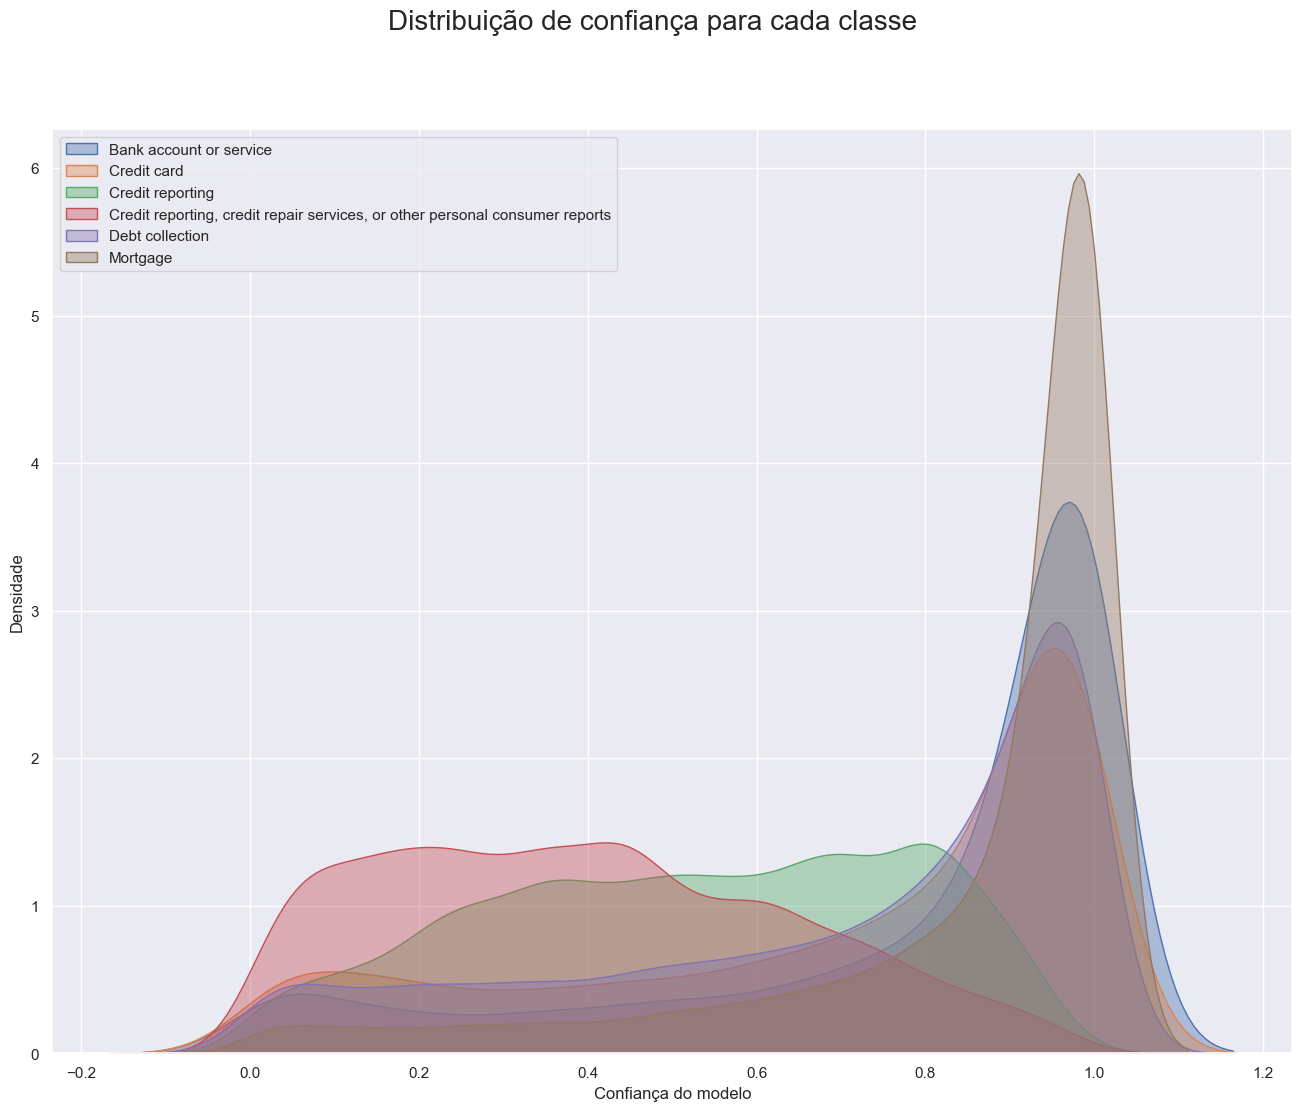

In [12]:
evaluate(ye_test, g.predict(x_test), g.predict_proba(x_test), labels=label_enc.classes_)

**Pergunta (1pt):** considerando o gráfico de distribuição de confiança para o seu modelo treinado, as amostras são classificadas com alta confiança? Há uma grande diferença de confiança entre as diferentes classes?

A confiança do modelo na maioria das classes é boa, com uma concentração expressiva entre 80% e 100%. No entanto, conseguimos perceber um espalhamento maior da distribuição para as classes "Credit reporting" e "Credit reporting, credit repair services, or other personal consumer reports". Esta diferença também é visível na matriz de confusão, onde é nítida a queda de acurácia entre as duas classes. Essa queda de performance faz sentido, já que os dois temas são ambíguos, tendo a ver com relatórios de crédito. As classes de "Bank account or service" e "Credit card" também apresentam um pouco de ambiguidade entre si, porém em nível muito menor. Este comportamento pode ser visto como um ligeiro aumento na cauda das distribuições de ambas as classes e ao observar as suas respectivas linhas na matriz de confusão (falsos positivos).

----------
----------

## Redes Neurais - Tensorflow
Iremos treinar alguns modelos de redes neurais, variando número de camadas e quantidade de neurônios em cada camada.

Vamos converter os rótulos em vetores *One Hot Encoded*:

In [ ]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

y_ohe_train = to_categorical(ye_train, num_classes=6)
y_ohe_test = to_categorical(ye_test, num_classes=6)

class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y=y_train)
train_class_weights = dict(enumerate(class_weights))

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema.

In [14]:
model = Sequential([
    Dense(50, activation='relu', input_shape=(features,)),
    Dense(6, activation='softmax')
])

model.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


c:\Users\Vitor\Desktop\Curso Unicamp - MDC\UnicampMDC2025\Supervisionado2\trabalhos\trabalho2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Treinando a rede neural

**Atividade (1 pt):** treine o modelo definido acima sobre o conjunto, respeitando as seguintes regras:

1. Separe um subconjunto do treino para validação.
2. Utilize alguma técnica para conservar os parâmetros que melhor generalizam o problema, como `ModelCheckpoint` (salve o modelo com nome de `weights.h5`).

In [26]:
nn_X_train, nn_X_val, nn_y_train, nn_y_val = train_test_split(x_train, y_ohe_train, test_size=0.2, stratify=y_train, random_state=42)
nn_X_test, nn_y_test = x_test, y_ohe_test

In [16]:
tf.random.set_seed(42)
np.random.seed(42)
epochs = 20
batch_size = 128


checkpoint = ModelCheckpoint(
    filepath="weights.h5",
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)


history = model.fit(
    nn_X_train, nn_y_train,
    validation_data=(nn_X_val, nn_y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=train_class_weights,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/20
713/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6637 - loss: 0.9569
Epoch 1: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7451 - loss: 0.7427 - val_accuracy: 0.7843 - val_loss: 0.5905
Epoch 2/20
689/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8116 - loss: 0.5554
Epoch 2: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8125 - loss: 0.5500 - val_accuracy: 0.7927 - val_loss: 0.5728
Epoch 3/20
689/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8338 - loss: 0.4860
Epoch 3: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8348 - loss: 0.4818 - val_accuracy: 0.7978 - val_loss: 0.5683
Epoch 4/20
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8514 - loss: 0.4291
Epoch 4: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8530 - loss: 0.4250 - val_accuracy: 0.7984 - val_loss: 0.5764
Epoch 5/20
703/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8674 - loss: 0.3798
Epoch 5: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8684 - loss: 0.3758 - val_accuracy: 0.8020 - val_loss: 0.5855
Epoch 6/20
708/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8816 - loss: 0.3366
Epoch 6: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8822 - loss: 0.3335 - val_accuracy: 0.8072 - val_loss: 0.5992
Epoch 7/20
703/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8937 - loss: 0.3000
Epoch 7: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8941 - loss: 0.2972 - val_accuracy: 0.8111 - val_loss: 0.6131
Epoch 8/20
691/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9036 - loss: 0.2677
Epoch 8: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9049 - loss: 0.2645 - val_accuracy: 0.8095 - val_loss: 0.6441
Epoch 9/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9136 - loss: 0.2397
Epoch 9: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9144 - loss: 0.2367 - val_accuracy: 0.8110 - val_loss: 0.6736
Epoch 10/20
690/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9222 - loss: 0.2161
Epoch 10: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9229 - loss: 0.2132 - val_accuracy: 0.8105 - val_loss: 0.7073
Epoch 11/20
689/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9291 - loss: 0.1955
Epoch 11: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9301 - loss: 0.1921 - val_accuracy: 0.8051 - val_loss: 0.7510
Epoch 12/20
698/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9356 - loss: 0.1760
Epoch 12: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9369 - loss: 0.1720 - val_accuracy: 0.8058 - val_loss: 0.7849
Epoch 13/20
689/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9422 - loss: 0.1598
Epoch 13: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9430 - loss: 0.1567 - val_accuracy: 0.8046 - val_loss: 0.8237
Epoch 14/20
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9481 - loss: 0.1435
Epoch 14: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9485 - loss: 0.1416 - val_accuracy: 0.8063 - val_loss: 0.8518
Epoch 15/20
715/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9528 - loss: 0.1309
Epoch 15: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9540 - loss: 0.1286 - val_accuracy: 0.8049 - val_loss: 0.8922
Epoch 16/20
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9578 - loss: 0.1197
Epoch 16: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9581 - loss: 0.1186 - val_accuracy: 0.8097 - val_loss: 0.9127
Epoch 17/20
691/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9618 - loss: 0.1092
Epoch 17: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9630 - loss: 0.1069 - val_accuracy: 0.8106 - val_loss: 0.9368


In [17]:
model.load_weights('weights.h5')

O método `model.fit` retorna `model.history`, e contem algumas informações interessantes a respeito do histórico de treinamento.

**Atividade (1 pt):** plote um gráfico de linhas exibindo a evolução dos valores da função *loss* sobre o conjunto de treino e validação. A partir de qual `epoch` a rede começou a super-especializar?

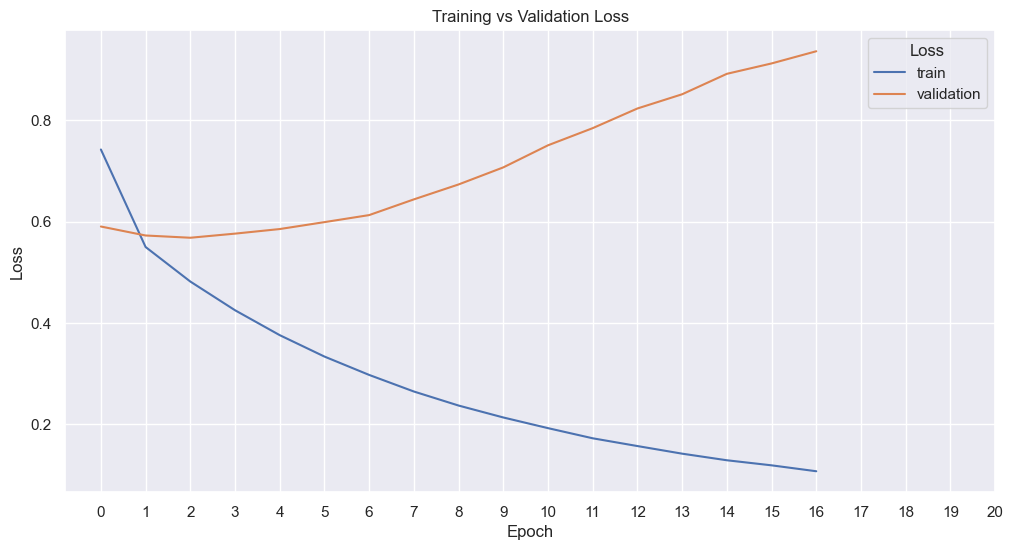

In [18]:
df = pd.DataFrame({
    'epoch': history.epoch,
    'train': history.history['loss'],
    'validation': history.history['val_loss']
})

# Melt to long format
df_melted = df.melt(id_vars='epoch', value_vars=['train', 'validation'],
                    var_name='Loss', value_name='loss')

# Plot
sns.lineplot(data=df_melted, x='epoch', y='loss', hue='Loss')
plt.title('Training vs Validation Loss')
plt.xticks(range(0, epochs+1, 1))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

A progressão da loss mostrou uma degradação rápida no gráfico, indicando que o modelo ainda não está conseguindo capturar bem a complexidade dos dados. A partir da época 3, o erro de validação já começou a subir de forma consistente, indicando um overfit do modelo, já que o erro de treinamento manteve uma queda constante.

### Avaliando o modelo treinado

**Atividade (1 pt):** teste o modelo treinado utilizando o subconjunto de teste. Reporte a acurácia para cada classe e a matriz de confusão percentual (usando a função `evaluate` definida anteriormente).

In [19]:
y_pred = model.predict(nn_X_test)

1543/1543 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Accuracy: 0.718
Accuracy (balanced): 0.703


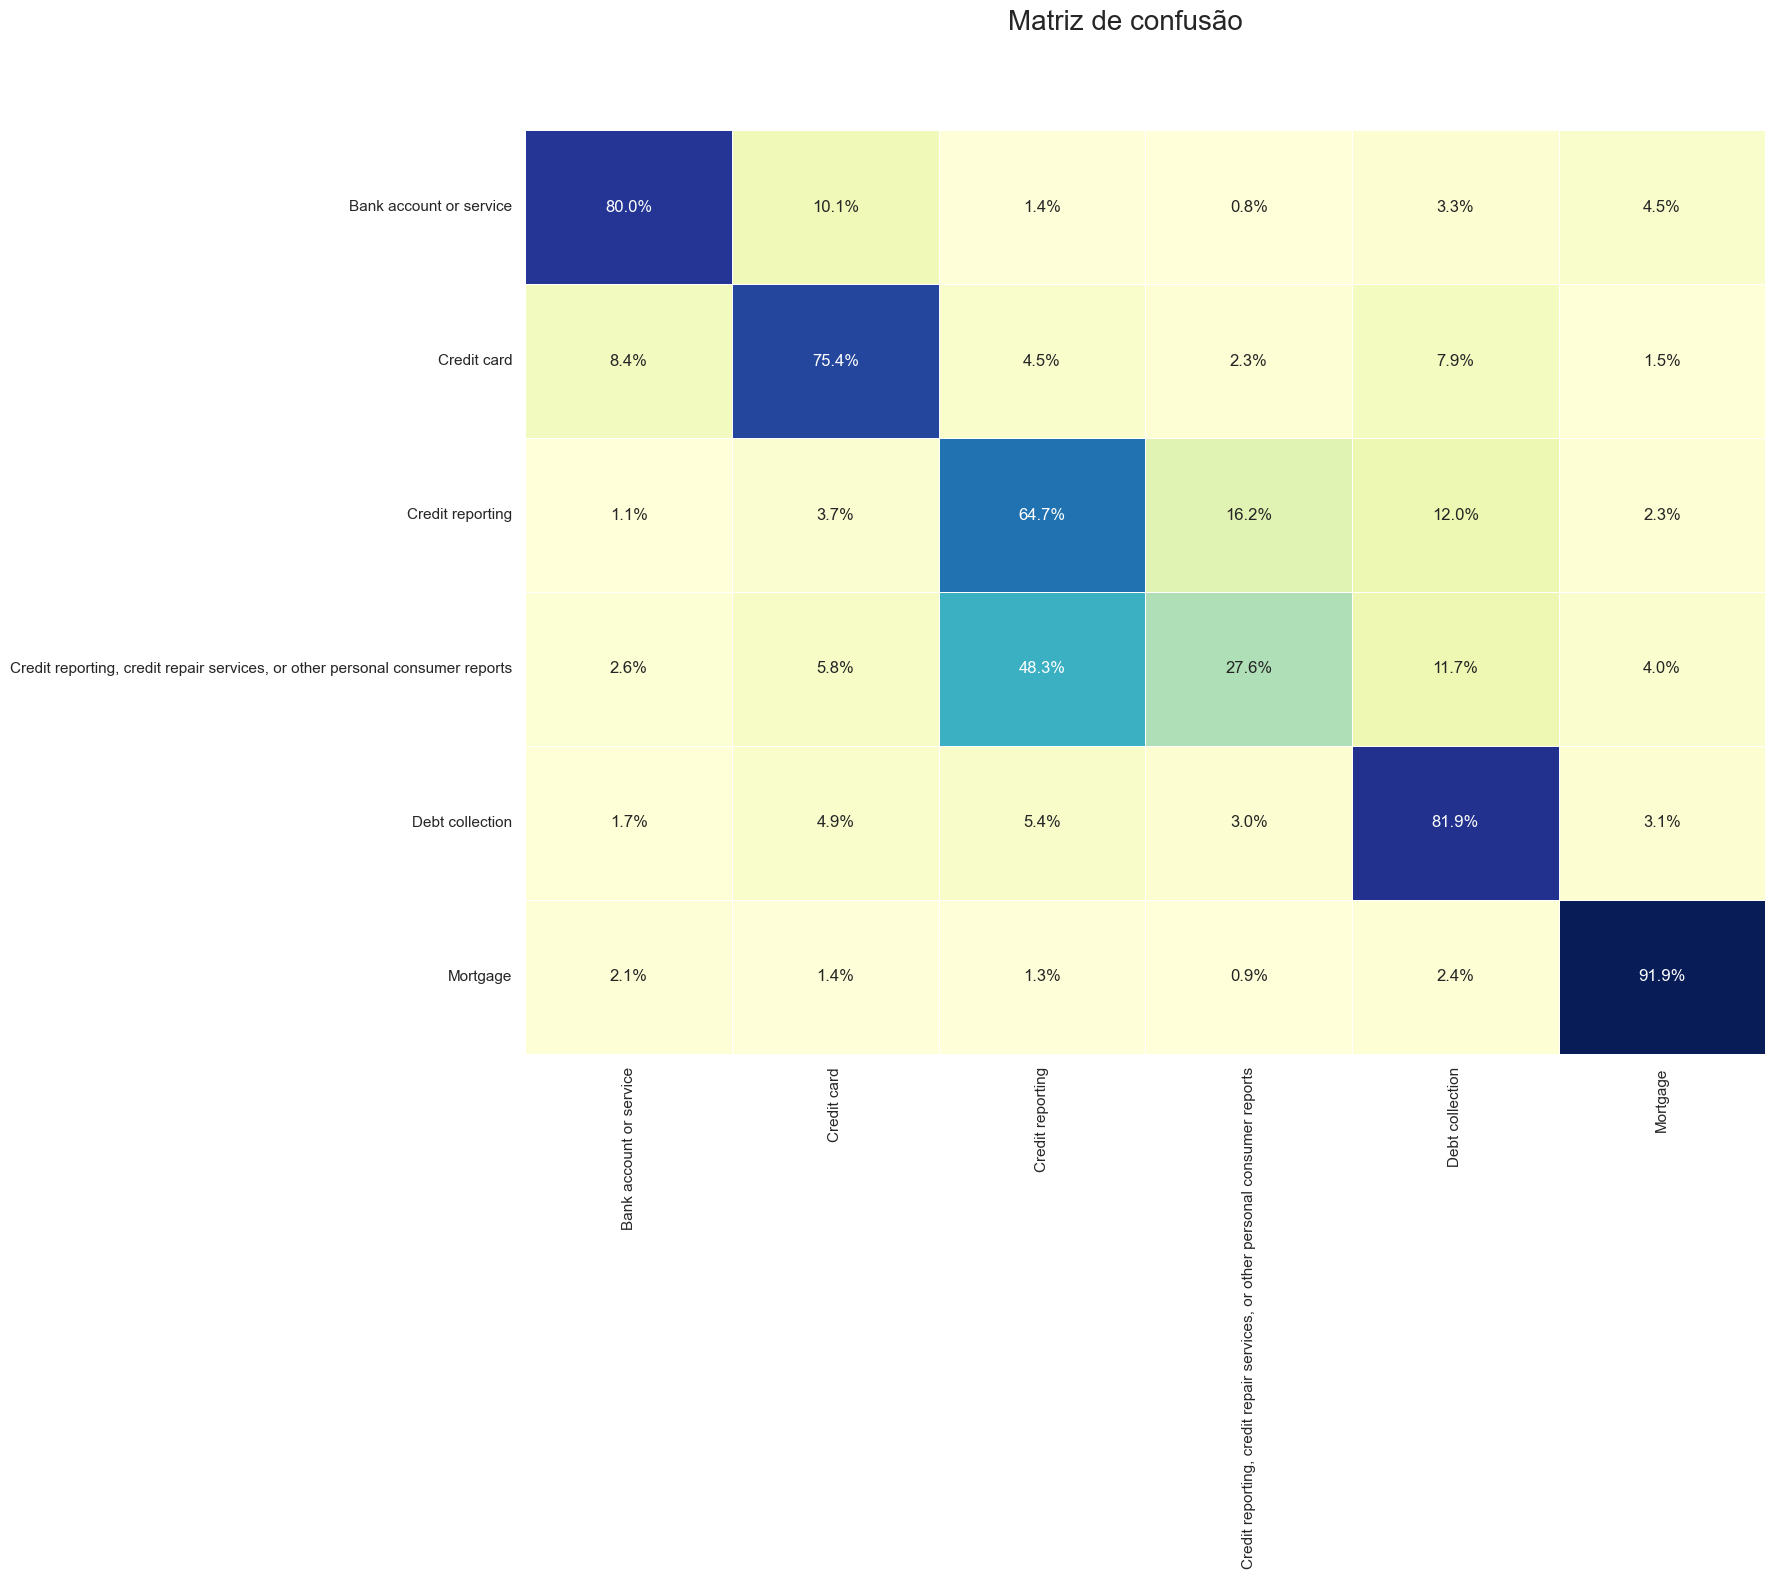

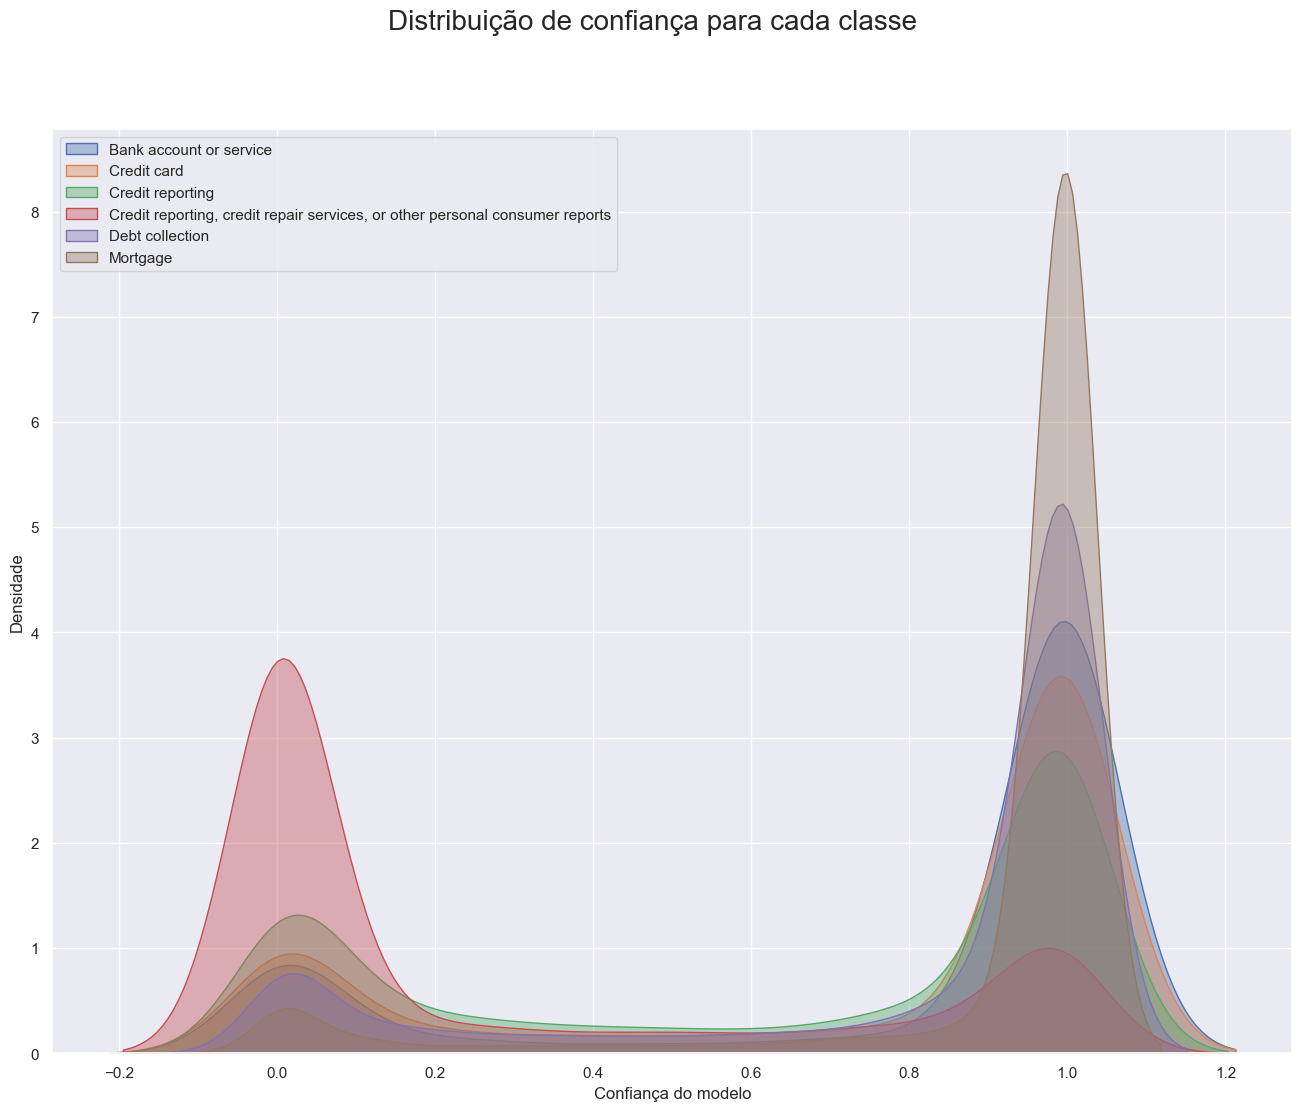

In [20]:
## para poder usar a função, precisei utilizar o dataset ye_test, sem one hot encoding
evaluate(ye_test, np.argmax(y_pred, axis=1), y_pred, labels=label_enc.classes_)

--------

Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

In [23]:
model2 = Sequential([
    Dense(128, activation='relu', input_shape=(features,)),
    Dense(32, activation='relu'),
    Dense(6, activation='softmax')
])

model2.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

**Atividade (1 pt):** treine a nova rede.

In [24]:
tf.random.set_seed(42)
np.random.seed(42)
epochs = 20
batch_size = 128


checkpoint2 = ModelCheckpoint(
    filepath="weights2.h5",
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop2 = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)


history2 = model.fit(
    nn_X_train, nn_y_train,
    validation_data=(nn_X_val, nn_y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=train_class_weights,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9837 - loss: 0.0577
Epoch 1: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9843 - loss: 0.0557 - val_accuracy: 0.8144 - val_loss: 1.2139
Epoch 2/20
706/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9859 - loss: 0.0513
Epoch 2: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9865 - loss: 0.0494 - val_accuracy: 0.8152 - val_loss: 1.2415
Epoch 3/20
709/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9874 - loss: 0.0481
Epoch 3: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9882 - loss: 0.0451 - val_accuracy: 0.8160 - val_loss: 1.2672
Epoch 4/20
702/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9893 - loss: 0.0430
Epoch 4: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9895 - loss: 0.0409 - val_accuracy: 0.8154 - val_loss: 1.2921
Epoch 5/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9901 - loss: 0.0412
Epoch 5: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9905 - loss: 0.0386 - val_accuracy: 0.8157 - val_loss: 1.3156
Epoch 6/20
709/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9909 - loss: 0.0377
Epoch 6: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9913 - loss: 0.0361 - val_accuracy: 0.8164 - val_loss: 1.3388
Epoch 7/20
711/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0362
Epoch 7: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9921 - loss: 0.0340 - val_accuracy: 0.8157 - val_loss: 1.3625
Epoch 8/20
706/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9925 - loss: 0.0337
Epoch 8: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9928 - loss: 0.0321 - val_accuracy: 0.8158 - val_loss: 1.3855
Epoch 9/20
706/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9928 - loss: 0.0341
Epoch 9: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9933 - loss: 0.0315 - val_accuracy: 0.8157 - val_loss: 1.4071
Epoch 10/20
692/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9934 - loss: 0.0304
Epoch 10: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9938 - loss: 0.0292 - val_accuracy: 0.8158 - val_loss: 1.4271
Epoch 11/20
718/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9936 - loss: 0.0295
Epoch 11: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9940 - loss: 0.0283 - val_accuracy: 0.8151 - val_loss: 1.4506
Epoch 12/20
695/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9940 - loss: 0.0295
Epoch 12: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9939 - loss: 0.0289 - val_accuracy: 0.8140 - val_loss: 1.4711
Epoch 13/20
712/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.0297
Epoch 13: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9945 - loss: 0.0274 - val_accuracy: 0.8145 - val_loss: 1.4911
Epoch 14/20
712/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9946 - loss: 0.0269
Epoch 14: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9948 - loss: 0.0254 - val_accuracy: 0.8148 - val_loss: 1.5079
Epoch 15/20
709/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9950 - loss: 0.0266
Epoch 15: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9952 - loss: 0.0248 - val_accuracy: 0.8150 - val_loss: 1.5266
Epoch 16/20
686/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9954 - loss: 0.0246
Epoch 16: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9955 - loss: 0.0232 - val_accuracy: 0.8150 - val_loss: 1.5446


**Atividade (1 pt):** adicione dropout ou regularização L1/L2 e treine o novo modelo. Se for, preciso, faça uma busca pelos hipeparâmetros da regularização/dropout.

**Atividade (1 pt):** avalie os modelos treinados e compare com os resultados anteriores.